In [12]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext viztracer
from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from typing import Dict, List, Tuple, Optional
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

import matplotlib.pyplot as plt
from nptyping.ndarray import NDArray
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import scipy
import scipy.stats

%matplotlib widget
import matplotlib.patches as patches
from matplotlib.widgets import Button


from neuropy.core.user_annotations import metadata_attributes, function_attributes

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses


@function_attributes(short_name=None, tags=['spearman', 'rank-order'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2023-12-08 12:33', related_items=[])
def calculate_spearman_correlation(spikes_df, shared_aclus_only_neuron_IDs, active_aclu_to_fragile_linear_neuron_IDX_dict, long_pf_peak_ranks, epoch_id:int=0, rank_alignment: str = 'first'):
    """ 
    Used to compute the spearman rank-order correlation from 
    
    History copied from `pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations.RankOrderAnalyses.compute_shuffled_rankorder_analyses`
        On 2023-12-08 
    
    """
    if len(spikes_df) < 2:
        return None

    output_dict = {}

    epoch_ranked_aclus_dict, epoch_ranked_fragile_linear_neuron_IDX_dict, epoch_selected_spikes_fragile_linear_neuron_IDX_dict, selected_spikes_only_df = RankOrderAnalyses.select_and_rank_spikes(spikes_df, active_aclu_to_fragile_linear_neuron_IDX_dict, rank_alignment, time_variable_name_override='t')

    ## TODO: might need to get the specific aclus that are active in the epoch and limit to the intersection of those and the current decoder:
    epoch_spikes_active_aclus = np.array(list(epoch_ranked_aclus_dict[epoch_id].keys())) # get the actual aclus instead of the indicies here.
    epoch_spikes_active_ranks = np.array(list(epoch_ranked_aclus_dict[epoch_id].values()))
    ## 2. Now get the template aclus to filter the epoch_active_aclus by (note there are way more `epoch_active_aclus` (like 81) than template ones.
    # shared_aclus_only_neuron_IDs # (for now). In the future the `template_aclus` might be template-specific instead of shared:
    template_aclus: NDArray = shared_aclus_only_neuron_IDs
    is_epoch_aclu_included_in_template: NDArray[np.bool_] = np.isin(epoch_spikes_active_aclus, template_aclus) # a bool array indicating whether each aclu active in the epoch (spikes_df) is included in the template.


    # BEGIN 2023-11-22 NEW Implementation: _______________________________________________________________________________ #

    # Chop the template down to the active spikes AND chop the active spikes down to the template:
    actually_included_epoch_aclus = epoch_spikes_active_aclus[is_epoch_aclu_included_in_template] # note this must be strictly smaller than the template aclus, AND strictly less than the epoch_active_aclus.
    actually_included_epoch_ranks = epoch_spikes_active_ranks[is_epoch_aclu_included_in_template]

    #TODO 2023-11-22 11:30: - [ ] Does chopping the template down vs. leaving those entries in there change the spearman?

    # long_pf_peak_ranks, short_pf_peak_ranks
    assert np.shape(long_pf_peak_ranks) == np.shape(shared_aclus_only_neuron_IDs)
    # assert np.shape(short_pf_peak_ranks) == np.shape(shared_aclus_only_neuron_IDs)
    
    # Chop the other direction:
    is_template_aclu_actually_active_in_epoch: NDArray = np.isin(template_aclus, actually_included_epoch_aclus) # a bool array indicating whether each aclu in the template is active in  in the epoch (spikes_df). Used for indexing into the template peak_ranks (`long_pf_peak_ranks`, `short_pf_peak_ranks`)
    template_epoch_actually_included_aclus: NDArray = np.array(template_aclus)[is_template_aclu_actually_active_in_epoch] ## `actually_included_template_aclus`: the final aclus for this template actually active in this epoch

    epoch_active_long_pf_peak_ranks = np.array(long_pf_peak_ranks)[is_template_aclu_actually_active_in_epoch]
    # epoch_active_short_pf_peak_ranks = np.array(short_pf_peak_ranks)[is_template_aclu_actually_active_in_epoch]
    #TODO 2023-11-22 11:35: - [ ] Is there the possibility that the template doesn't have spikes that are present in the epoch? I think so in general.
    # assert np.shape(epoch_active_short_pf_peak_ranks) == np.shape(actually_included_epoch_ranks), f"np.shape(epoch_active_short_pf_peak_ranks): {np.shape(epoch_active_short_pf_peak_ranks)}, np.shape(actually_included_epoch_ranks): {np.shape(actually_included_epoch_ranks)}\n\tTODO 2023-11-22 11:35: - [ ] Is there the possibility that the template doesn't have spikes that are present in the epoch? I think so in general." # 
    # assert np.shape(epoch_active_short_pf_peak_ranks) == np.shape(epoch_active_long_pf_peak_ranks)
    # NEW 2023-11-22 - So now have: actually_included_epoch_aclus, actually_included_epoch_ranks, (actually_included_template_aclus, epoch_active_long_pf_peak_ranks, epoch_active_short_pf_peak_ranks)

    # END NEW:

    # 4. Final step is getting the actual indicies into the template aclus (the template-relative neuronIDXs):
    _template_aclu_list = list(template_aclus) # convert to a temporary basic python list so that `.index(aclu)` works in the next line.
    template_epoch_neuron_IDXs: NDArray[int] = np.array([_template_aclu_list.index(aclu) for aclu in actually_included_epoch_aclus]) # should be the appropriate neuronIDXs in the template-relative array

    epoch_ranked_fragile_linear_neuron_IDXs_array = epoch_ranked_fragile_linear_neuron_IDX_dict[epoch_id]
    epoch_neuron_IDX_ranks = np.squeeze(epoch_ranked_fragile_linear_neuron_IDXs_array[is_epoch_aclu_included_in_template,1]) # the ranks just for this epoch, just for this template
    

    # FINAL NOTE: `actually_included_template_aclus`, `template_epoch_neuron_IDXs` contain the actual IDX and aclus for this template active during this epoch

    # Note that now (after boolean slicing), both `epoch_neuron_IDXs` and `epoch_neuron_IDX_ranks` can be LESS than the `shared_aclus_only_neuron_IDs`. They are indexed?
    # Instead of `epoch_neuron_IDXs`, use `template_epoch_neuron_IDXs` to the get neuron_IDXs relative to this template:`
    assert np.size(template_epoch_neuron_IDXs) == np.size(epoch_neuron_IDX_ranks), f"{np.size(epoch_neuron_IDX_ranks)} and len(template_epoch_neuron_IDXs): {np.size(template_epoch_neuron_IDXs)}"

    #TODO 2023-11-22 08:35: - [ ] keep da' indicies we actually use for this template/epoch. They're needed in the RankOrderRastersDebugger.
    output_dict[epoch_id] = (template_epoch_neuron_IDXs, template_epoch_actually_included_aclus, epoch_neuron_IDX_ranks) # might need multiple for each templates if they aren't clipped to shared.

    ## EPOCH SPECIFIC:
    long_spearmanr_rank_stats_results = []
    short_spearmanr_rank_stats_results = []

    # The "real" result for this epoch:
    # active_epoch_aclu_long_ranks = relative_re_ranking(long_pf_peak_ranks, template_epoch_neuron_IDXs, disable_re_ranking=disable_re_ranking) # encountering np.shape(epoch_neuron_IDXs): (41,) but np.shape(long_pf_peak_ranks): (34,)
    # real_long_rank_stats = scipy.stats.spearmanr(active_epoch_aclu_long_ranks, epoch_neuron_IDX_ranks)
    # NEW 2023-11-22: epoch_active_long_pf_peak_ranks mode:
    active_epoch_aclu_long_ranks = epoch_active_long_pf_peak_ranks
    real_long_rank_stats = scipy.stats.spearmanr(active_epoch_aclu_long_ranks, actually_included_epoch_ranks)
    real_long_result_corr_value = real_long_rank_stats.statistic

    return real_long_result_corr_value #, output_dict

@metadata_attributes(short_name=None, tags=['interactive', 'matplotlib', 'widget', 'jupyter', 'raster', 'spikes', 'debug', 'rank-order', 'spearman'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2023-12-08 12:31', related_items=[])
class InteractiveRasterBuilderWidget:
    """ displays an interactive raster plot widget that allows you to click to add "spikes" and assess the effects on spearman rank-order
    
    💚 2023-12-08 - Add interactivity to raster plot so I can click and drop a spike.
    
    """
    def __init__(self, num_neurons=10, time_window=100):
        self.num_neurons = num_neurons
        self.time_window = time_window
        self.epoch_id = 0
        self.erase_mode = False  # initialize erase mode to False
        
        self.shared_aclus_only_neuron_IDs = np.arange(self.num_neurons)
        self.active_aclu_to_fragile_linear_neuron_IDX_dict = dict(zip(self.shared_aclus_only_neuron_IDs, np.arange(self.num_neurons))) # 1:1 mapping

        self.long_pf_peak_ranks = np.arange(self.num_neurons)+1 # ranks are 1-indexed
        
        self.spikes_df = pd.DataFrame(columns=['t', 'aclu', 'Probe_Epoch_id', 'added_order'])
        self.fig, self.ax = plt.subplots()
        self.neuron_lines = [self.ax.plot([], [], 'o', color=plt.cm.jet(i / self.num_neurons))[0] for i in range(self.num_neurons)]
        self.setup_plot()
        self.connect_events()

    def setup_plot(self):
        self.ax.set_xlim(0, self.time_window)
        self.ax.set_ylim(0, self.num_neurons)
        self.ax.set_xlabel('Time (ms)')
        self.ax.set_ylabel('Neuron')
        self.correlation_text = self.ax.text(0.5, 1.05, '', transform=self.ax.transAxes, ha='center')

        self.colors = plt.cm.jet(np.linspace(0, 1, self.num_neurons))
        self.neuron_lines = [self.ax.plot([], [], 'o', color=self.colors[i])[0] for i in range(self.num_neurons)]
        self.highlight_rect = patches.Rectangle((0, -0.5), self.time_window, 1, color='gray', alpha=0.3, visible=False) # used to highlight the currently hovered line
        self.ax.add_patch(self.highlight_rect)
        
        # had cell line hover rects:
        for i in range(self.num_neurons):
            line, = self.ax.plot([], [], 'o', color=self.colors[i], label=f'Neuron {i+1}')
            self.neuron_lines.append(line)
    
        # Add buttons
        ax_clear = plt.axes([0.7, 0.05, 0.1, 0.075])
        ax_save = plt.axes([0.81, 0.05, 0.1, 0.075])
        ax_erase = plt.axes([0.1, 0.05, 0.1, 0.075])
        
        self.btn_clear = Button(ax_clear, 'Clear')
        self.btn_save = Button(ax_save, 'Save')
        self.btn_erase = Button(ax_erase, 'Erase')  # create erase button
        self.btn_erase.on_clicked(self.toggle_erase_mode)  # connect erase button to toggle_erase_mode function
        self.btn_clear.on_clicked(self.clear_spikes)
        self.btn_save.on_clicked(self.save_figure)

        # Output widgets
        self.click_catcher = widgets.Output()
        display(self.click_catcher)
        self.accumulated_saved_output = widgets.Output()
        display(self.accumulated_saved_output)

    def connect_events(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def toggle_erase_mode(self, event):
        self.erase_mode = not self.erase_mode  # toggle erase mode
        if self.erase_mode:
            self.btn_erase.label.set_text('Add')  # change button label to 'Add' when in erase mode
        else:
            self.btn_erase.label.set_text('Erase')  # change button label back to 'Erase' when not in erase mode
            
    def on_click(self, event):
        """ when the user clicks within the plot object. """
        if self.erase_mode:  # check if in erase mode
            self.erase_spike(event)  # call erase_spike function
        else:
            self.update_plot({'type': 'change', 'name': 'value', 'new': (event.xdata, event.ydata)})
        
    def erase_spike(self, event):
        x, y = event.xdata, event.ydata
        neuron_index = int(y)
        if 0 <= neuron_index < self.num_neurons:
            self.spikes_df = self.spikes_df[(self.spikes_df['t'] != x) | (self.spikes_df['aclu'] != neuron_index)]
            self.spikes_df = self.spikes_df.sort_values(['t', 'aclu'])
            for i in range(self.num_neurons):
                neuron_data = self.spikes_df[self.spikes_df['aclu'] == i]
                self.neuron_lines[i].set_data(neuron_data['t'], neuron_data['aclu'])
            
            correlation = calculate_spearman_correlation(self.spikes_df, shared_aclus_only_neuron_IDs=self.shared_aclus_only_neuron_IDs, active_aclu_to_fragile_linear_neuron_IDX_dict=self.active_aclu_to_fragile_linear_neuron_IDX_dict, long_pf_peak_ranks=self.long_pf_peak_ranks, epoch_id=self.epoch_id)
            if correlation is not None:
                self.correlation_text.set_text(f'Spearman Correlation: {correlation:.2f}')
            else:
                self.correlation_text.set_text('Insufficient data for Spearman Correlation')

            self.fig.canvas.draw()
            

    def on_motion(self, event):
        """ when the user's hover moves within the plot object. """
        if event.inaxes == self.ax:
            neuron_index = int(event.ydata)
            if 0 <= neuron_index < self.num_neurons:
                self.highlight_rect.set_y(neuron_index - 0.5)
                self.highlight_rect.set_facecolor(self.colors[neuron_index])
                self.highlight_rect.set_visible(True)
                self.fig.canvas.draw_idle()
            else:
                self.highlight_rect.set_visible(False)
                self.fig.canvas.draw_idle()


    def update_plot(self, change):
        """ called with the matplotlib click event to update the plot. """
        if change['type'] == 'change' and change['name'] == 'value':
            x, y = change['new']
            neuron_index = int(y)
            if 0 <= neuron_index < self.num_neurons:
                self.spikes_df = self.spikes_df.append({'t': x, 'aclu': neuron_index, 'Probe_Epoch_id': self.epoch_id, 'neuron_type': 'pyr', 'added_order': len(self.spikes_df)}, ignore_index=True)
                self.spikes_df = self.spikes_df.sort_values(['t', 'aclu'])
                for i in range(self.num_neurons):
                    neuron_data = self.spikes_df[self.spikes_df['aclu'] == i]
                    self.neuron_lines[i].set_data(neuron_data['t'], neuron_data['aclu'])
                
                correlation = calculate_spearman_correlation(self.spikes_df, shared_aclus_only_neuron_IDs=self.shared_aclus_only_neuron_IDs, active_aclu_to_fragile_linear_neuron_IDX_dict=self.active_aclu_to_fragile_linear_neuron_IDX_dict, long_pf_peak_ranks=self.long_pf_peak_ranks, epoch_id=self.epoch_id)
                if correlation is not None:
                    self.correlation_text.set_text(f'Spearman Correlation: {correlation:.2f}')
                else:
                    self.correlation_text.set_text('Insufficient data for Spearman Correlation')

                self.fig.canvas.draw()

    def clear_spikes(self, event):
        self.spikes_df = pd.DataFrame(columns=['t', 'aclu', 'Probe_Epoch_id', 'added_order'])
        for line in self.neuron_lines:
            line.set_data([], [])
        self.fig.canvas.draw()

    def save_figure(self, event):
        with self.accumulated_saved_output:
            self.accumulated_saved_output.clear_output(wait=True)
            display(self.fig)



Automatic pdb calling has been turned OFF
The viztracer extension is already loaded. To reload it, use:
  %reload_ext viztracer
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Output()

Output()

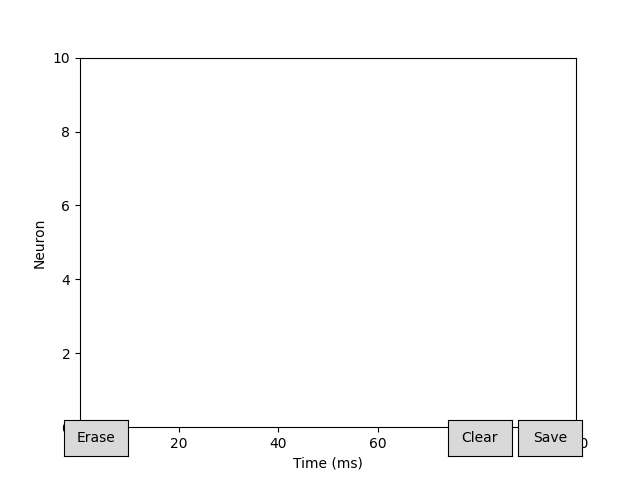

In [13]:
# Usage
plot = InteractiveRasterBuilderWidget()
plot

write a python script that generates an interactive raster plot with 10 rows (each corresponding to a different neuron) where you can click anywhere to add a "spike". Each row should be a different color, and 100ms should be shown.
Use a pd.DataFrame named `spikes_df` with the columns ['t', 'aclu'] where 'aclu' refers to the neuron_id instead of `spike_data` to hold the spikes.
I'd like to use `np.spearman` to compute the rank-order value of the spike data each time the plot is updated and display that value as a label on the plot

great, can you suggest a modification that highlights the currently hovered row with a faint highlight of the spike color, to make it easier to see what unit spikes will be created for?